In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [3]:
from sklearn.datasets import load_boston
X_b, y_b = load_boston(return_X_y=True)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2)

In [5]:
X_train.shape

(404, 13)

In [6]:
y_train.shape

(404,)

In [45]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [46]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [47]:
def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [48]:
import seaborn as sns

## GP RBF regression
 - Test RMSE
 - Train RMSE
 - Test NLL
 - Train NLL
 - Histogram for test and training error

In [61]:
m1 = GPy.models.GPRegression(X_train, y_train)

In [62]:
m1.optimize()

In [63]:
m1f_t, m1v_t = m1.predict(X_test)

In [64]:
m1f_tr, m1v_tr = m1.predict(X_train)

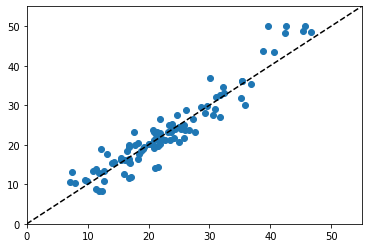

In [65]:
plt.scatter(m1f_t,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

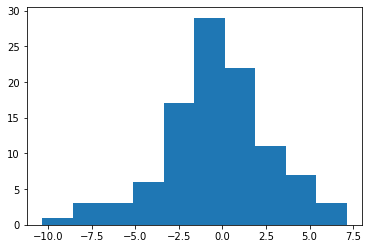

In [66]:
plt.hist(m1f_t-y_test)
plt.show()

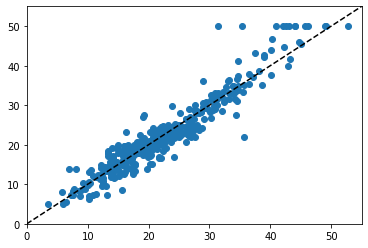

In [68]:
plt.scatter(m1f_tr,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

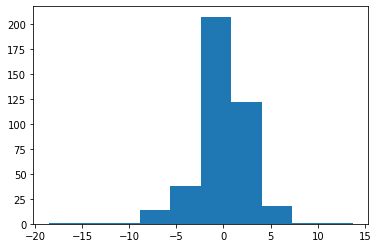

In [69]:


#y_train = np.array(y_train).reshape(-1,1)
#y_test = np.array(y_test).reshape(-1,1)
#train_error_gprbf = np.array(m1f_tr-y_train) 
#sns.distplot(m1f_tr-y_train, kde=False, rug=True);
#print(m1f_tr-y_train)
plt.hist(m1f_tr-y_train)
plt.show()


## GP deep RBF (SE_SE)

In [79]:
d_rbf = deepRBF(input_dim=X_train.shape[1])
m2 = GPy.models.GPRegression(X_train, y_train,d_rbf)

In [80]:
m2.optimize()

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in power


In [81]:
m2f_t, m2v_t = m2.predict(X_test)
m2f_tr, m2v_tr = m2.predict(X_train)

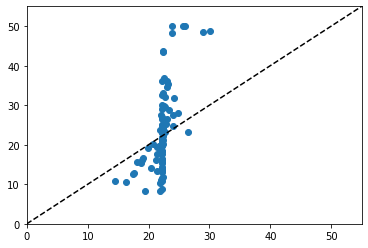

In [82]:
plt.scatter(m2f_t,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

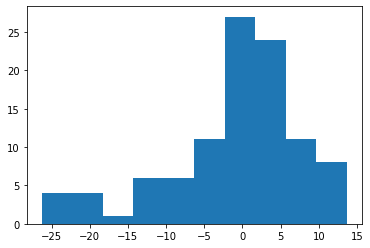

In [83]:
plt.hist(m2f_t-y_test)
plt.show()

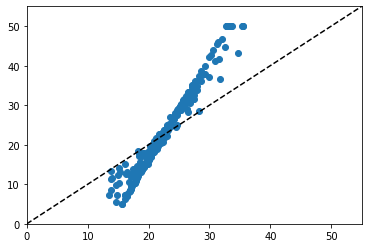

In [85]:
plt.scatter(m2f_tr,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

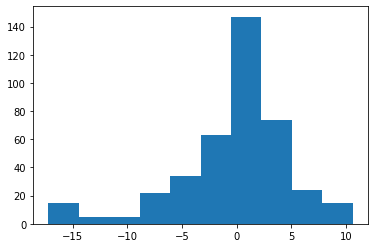

In [86]:
plt.hist(m2f_tr-y_train)
plt.show()

## Deep GP

In [90]:
import deepgp

In [124]:
hidden = 1
m_deep = deepgp.DeepGP([1,hidden,X_train.shape[1]],Y=y_train, X=X_train, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(X_train.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

In [144]:
for layer in m_deep.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m_deep.optimize(messages=True,max_iters=500)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [145]:
md, vd = m_deep.predict(X_train)
print(compute_nll(y_train,md,vd))

3.6217157076226276


In [146]:
mdt, vdt = m_deep.predict(X_test)
print(compute_nll(y_test,mdt,vdt))

3.707238214913623


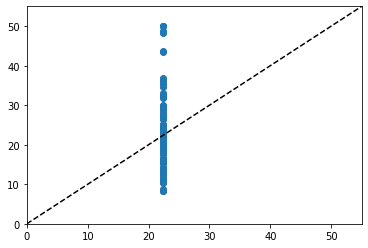

In [147]:
plt.scatter(mdt,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

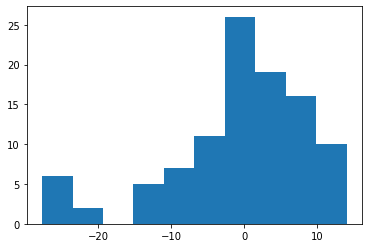

In [148]:
plt.hist(mdt-y_test)
plt.show()

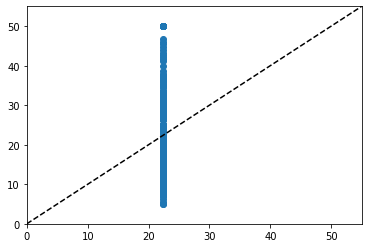

In [149]:
plt.scatter(md,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

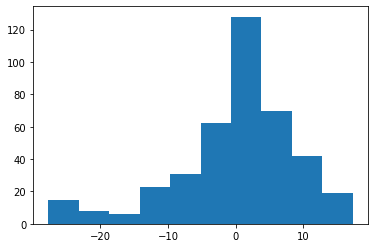

In [150]:
plt.hist(md-y_train)
plt.show()

### Report GP RBF

In [132]:
# test error for GP RBF
print(rmse(m1f_t,y_test))

3.0972131025049476


In [133]:
# Training RMSE for GP RBF
print(rmse(m1f_tr,y_train))

2.8900871431179094


In [134]:
# Test NLL
print(compute_nll(y_test,m1f_t,m1v_t))

9.259516151577255


In [135]:
# Train NLL
print(compute_nll(y_train,m1f_tr,m1v_tr))

8.638045750247807


### Report GP Deep RBF

In [136]:
# test error for GP deep RBF
print(rmse(m2f_t,y_test))

8.667924929313436


In [137]:
# Training RMSE for GP deepRBF
print(rmse(m2f_tr,y_train))

5.170324706108909


In [138]:
# Test NLL
print(compute_nll(y_test,m2f_t,m2v_t))

3.9068422920711003


In [139]:
# Train NLL
print(compute_nll(y_train,m2f_tr,m2v_tr))

3.9864873450778946


### Report Deep GP

In [151]:
print(rmse(y_test,mdt))

9.750317163007029


In [152]:
print(rmse(y_train,md))

9.043830514936559


In [153]:
# Test NLL
print(compute_nll(y_test,mdt,vdt))

3.707238214913623


In [154]:
# Train NLL
print(compute_nll(y_train,md,vd))

3.6217157076226276
